In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import math
import numpy as np

class DataSet():
    def __init__(self, num_words=None, seed=113, maxlen=100, train_portion=0.5, long_first=False):
        """
        :param num_words: Size of vocabulary, all words out-of-vocabulary will be marked as [unk]
        :param seed: Seed for randomly shuffling dataset
        :param maxlen: Maximum length of review, reviews longer than maxlen will be truncated, reviews shorter than
        maxlen will be padded to maxlen
        :param train_portion: Portion of dataset to allocate to training data, test data will be 1-train_portion
        :param long_first: Sort reviews by length
        """
        # retrieve IMDb data, x is a sequence containing movie review,
        # y is a label indicating if it is positive or negative sentiment
        (self.x_train, self.y_train), (self.x_test, self.y_test) = imdb.load_data(num_words=num_words, seed=seed)

        if long_first:
            self.y_train = [y for _, y in sorted(zip(self.x_train, self.y_train), key=lambda s: len(s[0]), reverse=True)]
            self.x_train = sorted(self.x_train, key=len, reverse=True)

            self.y_test = [y for _, y in sorted(zip(self.x_test, self.y_test), key=lambda s: len(s[0]), reverse=True)]
            self.x_test = sorted(self.x_test, key=len, reverse=True)

        self.total_length = [len(x) for x in self.x_train]
        temp = [len(x) for x in self.x_test]
        self.total_length.extend(temp)

        # padding sequences to all be of the same length
        self.x_train = pad_sequences(self.x_train, maxlen=maxlen, padding='post', truncating='post')
        self.x_test = pad_sequences(self.x_test, maxlen=maxlen, padding='post', truncating='post')

        self.split_data(train_portion)

        self.word_index = imdb.get_word_index()
        self.word_to_index = {word:id + 3 for word, id in self.word_index.items()}
        self.word_to_index["[pad]"] = 0
        self.word_to_index["[start]"] = 1
        self.word_to_index["[unk]"] = 2
        self.word_to_index["[unused]"] = 3
        self.index_to_word = {i:word for (word, i) in self.word_to_index.items()}
        self.form_vocab()

    def form_vocab(self):
        i2w_vocab = {}
        w2i_vocab = {}

        for sentence in self.x_train:
            for id in sentence:
                if id not in i2w_vocab:
                    word = self.index_to_word[id]
                    i2w_vocab[id] = word
                    w2i_vocab[word] = id

        for sentence in self.x_test:
            for id in sentence:
                if id not in i2w_vocab:
                    word = self.index_to_word[id]
                    i2w_vocab[id] = word
                    w2i_vocab[word] = id
        self.i2w_vocab = i2w_vocab
        self.w2i_vocab = w2i_vocab

    def get_data(self):
        return (self.x_train, self.y_train), (self.x_test, self.y_test), (self.train_length, self.test_length)

    def get_vocab_length(self):
        return len(self.i2w_vocab)

    # splits data into ratio train:test -> (train_portion:1-train_portion)
    def split_data(self, train_portion):
        x = np.concatenate((self.x_train, self.x_test), axis=0)
        y = np.concatenate((self.y_train, self.y_test), axis=0)
        self.train_length, self.test_length = self.total_length[:math.floor(train_portion * len(x))], \
                                              self.total_length[math.floor(train_portion * len(x)):]
        self.x_train, self.x_test = x[:math.floor(train_portion * len(x))], \
                                    x[math.floor(train_portion * len(x)):]
        self.y_train, self.y_test = y[:math.floor(train_portion * len(y))], \
                                    y[math.floor(train_portion * len(y)):]
        return None


2023-08-12 14:35:33.661333: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [55]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
import tensorflow.keras.regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.datasets import imdb
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
import numpy as np
import matplotlib as matplot
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import math
# from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
import pickle
from tensorflow.keras.layers import GaussianNoise
maxlen = 500
batch_size = 50
VOCAB_size = 4000
INPUT_SIZE=500
dataset = DataSet(VOCAB_size, maxlen=INPUT_SIZE, train_portion=0.7)
with open('unitc/dataset_4000_70.pkl', 'wb') as f:
    pickle.dump(dataset, f)
(x_train, y_train), (x_test, y_test),(_,_) = dataset.get_data()

In [4]:
class Word2Vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.target_embedding = layers.Embedding(vocab_size,
                                          embedding_dim,
                                          input_length=1,
                                          name="w2v_embedding")
        self.context_embedding = layers.Embedding(vocab_size,
                                           embedding_dim,
                                           input_length=num_ns+1)

    def call(self, pair):
        target, context = pair
            # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
            # context: (batch, context)
        if len(target.shape) == 2:
            target = tf.squeeze(target, axis=1)
            # target: (batch,)
        word_emb = self.target_embedding(target)
            # word_emb: (batch, embed)
        context_emb = self.context_embedding(context)
            # context_emb: (batch, context, embed)
        dots = tf.einsum('be,bce->bc', word_emb, context_emb)
            # dots: (batch, context)
        return dots

In [5]:
def custom_loss(x_logit, y_true):
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

In [56]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
import numpy as np
x_train=x_train.tolist()+x_test.tolist()
x_train=np.array(x_train)
print(x_train.shape)
# Create sentences for Word2Vec
train_sentences = [[str(word) for word in sequence] for sequence in x_train]

# Train Word2Vec model
EMBEDDING_SIZE = 32
CONTEXT_WINDOW = 5
MIN_WORD_FREQUENCY = 5

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=train_sentences, vector_size=EMBEDDING_SIZE, window=CONTEXT_WINDOW, min_count=MIN_WORD_FREQUENCY, sg=1)

# Transform x_train sequences to (500*32) dimension vectors
x_train_embedded = np.zeros((x_train.shape[0], maxlen, EMBEDDING_SIZE))
for i, sequence in enumerate(train_sentences):
    embedding_sequence = []
    for word in sequence:
        if word in word2vec_model.wv:
            embedding_sequence.append(word2vec_model.wv[word])
    x_train_embedded[i] = np.array(embedding_sequence)


(50000, 500)


In [57]:
x_train_embedded.shape

(50000, 500, 32)

In [32]:
(x_train, y_train), (x_test, y_test),(_,_) = dataset.get_data()
x_train.shape

(35000, 500)

In [58]:
with open('word2vec/x_train_embedded.pkl', 'wb') as f:
    pickle.dump(x_train_embedded, f)

In [44]:
with open('x_train_embedded.pkl', 'rb') as f:
    x_train_embedded = pickle.load(f)

(50000, 500, 32)

In [ ]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
import tensorflow.keras.regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.datasets import imdb
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
import numpy as np
import matplotlib as matplot
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import math
# from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
import pickle
from tensorflow.keras.layers import GaussianNoise
np.random.seed(42)
#set up hyperparameters
# max_features = 50000
maxlen = 500
batch_size = 50
VOCAB_size = 4000
INPUT_SIZE=500
dataset = DataSet(VOCAB_size, maxlen=INPUT_SIZE, train_portion=0.7)
with open('word2vec/dataset_4000_70.pkl', 'wb') as f:
    pickle.dump(dataset, f)
(x_train,y_train), (x_test, y_test),(_,_) = dataset.get_data()
#vocab_size = dataset.get_vocab_length()
with open('word2vec/x_train_embedded.pkl', 'rb') as f:
    x_train_embedded = pickle.load(f)
x_train=x_train_embedded[:35000]
x_test=x_train_embedded[35000:]

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

        
model_s = keras.Sequential()
model_s.add(LSTM(32))
model_s.add(tf.keras.layers.Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model_s.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

#def schedule(epoch):
    #if epoch < 20:
        #return 0.0005
    #if epoch < 200:
        #return 0.0001
    #if epoch < 300:
        #return 0.00005
    #if epoch < 900:
        #return 0.00001
    #else:
        #return 0.000005

#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule)




#model.predict(x_test)



checkpoint_filepath='word2vec/weights.{epoch:02d}.hdf5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor= 'val_loss',
    verbose= 0,
    save_best_only= False,
    save_weights_only = False,
    mode= 'auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None
)

history = model_s.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=1000,
                    validation_data=(x_test, y_test),
                     callbacks=[model_checkpoint_callback])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))



plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()



x_train shape: (35000, 500, 32)
x_test shape: (15000, 500, 32)
Epoch 1/1000


2023-08-13 06:35:59.154590: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-13 06:35:59.156784: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-13 06:35:59.158434: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

698/700 [============================>.] - ETA: 0s - loss: 0.6925 - accuracy: 0.5081

2023-08-13 06:36:18.613456: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-13 06:36:18.615722: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-13 06:36:18.617364: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

700/700 [==============================] - 23s 30ms/step - loss: 0.6925 - accuracy: 0.5081 - val_loss: 0.6890 - val_accuracy: 0.5129
Epoch 2/1000
700/700 [==============================] - 20s 28ms/step - loss: 0.6927 - accuracy: 0.5065 - val_loss: 0.6936 - val_accuracy: 0.5018
Epoch 3/1000
700/700 [==============================] - 24s 34ms/step - loss: 0.6921 - accuracy: 0.5079 - val_loss: 0.6914 - val_accuracy: 0.5059
Epoch 4/1000
700/700 [==============================] - 20s 29ms/step - loss: 0.6900 - accuracy: 0.5130 - val_loss: 0.6921 - val_accuracy: 0.5051
Epoch 5/1000
700/700 [==============================] - 23s 33ms/step - loss: 0.6877 - accuracy: 0.5213 - val_loss: 0.6862 - val_accuracy: 0.5167
Epoch 6/1000
700/700 [==============================] - 25s 36ms/step - loss: 0.6723 - accuracy: 0.5739 - val_loss: 0.6593 - val_accuracy: 0.5961
Epoch 7/1000
700/700 [==============================] - 25s 36ms/step - loss: 0.6321 - accuracy: 0.6555 - val_loss: 0.5909 - val_accuracy

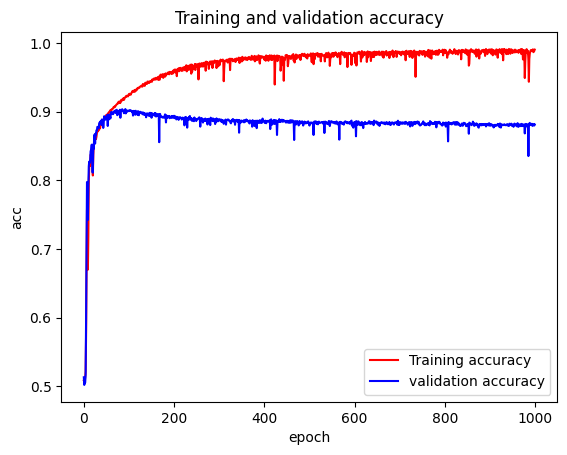

<Figure size 640x480 with 0 Axes>

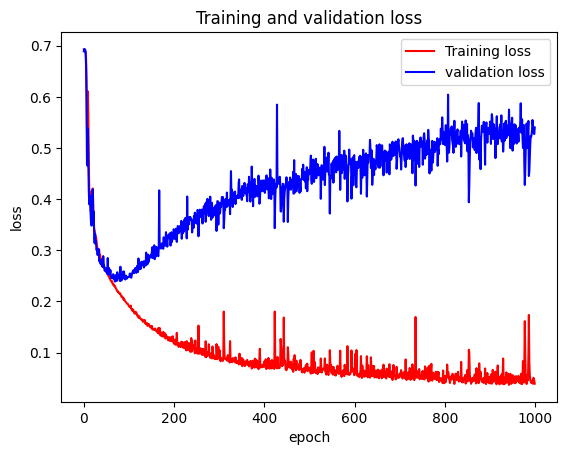

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
with open('word2vec/acc.pkl', 'wb') as f:
    pickle.dump(acc, f)
with open('word2vec/vacc.pkl', 'wb') as f:
    pickle.dump(val_acc, f)
with open('word2vec/loss.pkl', 'wb') as f:
    pickle.dump(loss, f)
with open('word2vec/vloss.pkl', 'wb') as f:
    pickle.dump(val_loss, f)
    
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.savefig('word2vec/acc.png')
plt.figure()
plt.show()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.savefig('word2vec/loss.png')
plt.legend()
plt.show()

